In [ ]:
IS_LINUX = False
from sys import platform
if platform == "linux" or platform == "linux2":
  IS_LINUX = True
if IS_LINUX:
    !pip install tensorflow-gpu
    !pip install jsonpickle

In [ ]:
if IS_LINUX:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [ ]:
if IS_LINUX:
    %cd /content/drive/My\ Drive/MastersThesis
    !ls
    !pwd
    import sys
    sys.path.append('./')

In [ ]:
import global_functions
global_functions.on_start()

In [ ]:
import tensorflow as tf
print(tf.__version__)
#2.0.0

In [ ]:
import experiments, datasets, training_data
import models
import constants
import vizualizer

from global_functions import on_start
on_start()

def autoencoder_classifier_together(autoencoder_layers_trainable_during_classification_training: bool):
    for classifier_rate in [0.1, 0.25, 0.5, 1]:
        exp = experiments.ExperimentAutoencoderAndClassifier(
            datasets.DatasetProviderClass(datasets.FashionMnistDataset),
            models.BasicModelProvider(),
            training_data.BasicTrainingDataGeneratorAutoencoderClassifier())
        parameters_autoencoder = training_data.TrainParameters(1, 128, None, False, 1.0, 1e-7)
        parameters_classifier = training_data.TrainParameters(1, 128, None, True, classifier_rate, 1e-7)
        parameters = training_data.BasicTrainParametersTwoModels(parameters_autoencoder, parameters_classifier, 150,
                                                                 autoencoder_layers_trainable_during_classification_training,
                                                                 constants.ExperimentsPaths.FashionMnist.AUTOENCODER1_CLASSIFIER1_AUTO_L_ON
                                                                 if autoencoder_layers_trainable_during_classification_training else
                                                                 constants.ExperimentsPaths.FashionMnist.AUTOENCODER1_CLASSIFIER1_AUTO_L_OFF,
                                                                 True)
        exp.train(parameters)


# 4
autoencoder_classifier_together(True)

In [ ]:
import models as models
import datasets
import importlib
importlib.reload(models)
model = models.BasicModelProvider()(datasets.FashionMnistDataset())

In [ ]:
model.classifier.summary()

In [ ]:
provider = models.ExistingModelProvider(lambda : model)
exp.model_provider = provider

In [ ]:
model, result = exp.train(training_data.BasicTrainParametersAutoencoder(15, 128, 20, True, 1.0, 0.0001, None,None))

In [545]:
import vizualizer, experiments , constants, importlib, datasets, models
importlib.reload(experiments)
importlib.reload(vizualizer)
importlib.reload(models)
importlib.reload(constants)


results = experiments.ExperimentBase.load_experiment_results(constants.ExperimentsPaths.Mnist.CLASSIFIER, True)
experiment = results[-1].experiment
#print(len(results))    
#vizualizer.Vizualizer.vizualize([result.train_history for result in results], 0.5)

In [546]:
trained_models = experiment.model_provider()

In [555]:
last_layer = trained_models.classifier.layers[-1]
print(last_layer.activation)

<function sigmoid at 0x000002275C6CD2F0>


In [558]:
trained_models.make_classifier_without_activation()
#trained_models.make_classifier_with_sigmoid_activation()
#trained_models.make_classifier_with_softmax_activation()

In [212]:
mnist_predictions = experiments.ExperimentClassifier.predict_test(datasets.MnistDataset(), trained_models)
#mnist_predictions = np.max(mnist_predictions, axis = 1)
fashion_mnist_predictions = experiments.ExperimentClassifier.predict_test(datasets.FashionMnistDataset(), trained_models)
#fashion_mnist_predictions = np.max(fashion_mnist_predictions, axis = 1)

10000/1 - 1s
Correct: 898
10000/1 - 1s
Correct: 9384


In [265]:
def print_predictins(predictions, dataset, start = 0, end = 10):
    for index in range(start, end):
        item = predictions[index]
        print(item)
        my_prediction = item.argmax()
        correct_index = dataset.get_test_labels()[index]
        print(item[correct_index])
        print("Correct:", my_prediction == correct_index)
        print("sum abs: ", sum(np.abs(item)) )
#print_predictins(fashion_mnist_predictions, datasets.FashionMnistDataset())

fashion_mnist_abs = np.sum(np.square(mnist_predictions) , axis = 1)
fashion_mnist_abs[0:10]




In [538]:
from abc import ABC, abstractmethod

class Predictor(ABC):
    def predict_train(self, dataset, model, threashold = None):
        return self.predict(dataset.get_train_images(), dataset.get_train_labels(), model, threashold)
        
    def predict_test(self, dataset, model, threashold = None):
        return self.predict(dataset.get_test_images(), dataset.get_test_labels(), model, threashold)
        
    def predict_test_based_on_train_treshoald(self, dataset, model, percentile):
        _, distance_train = self.predict_train(dataset, model)
        threashold_for_test =  np.percentile(distance_train, percentile)
        return self.predict_test(dataset, model, threashold_for_test), threashold_for_test
    
    @abstractmethod
    def predict(self, images, labels , model, threashold):
        pass
    

class AbsDistanceFromPredicted(Predictor):    
    
    def predict(self, images, labels , model, threashold):
        predictions = model.classifier.predict(images)
        my_classes = predictions.argmax(axis = 1)
        distances = np.zeros_like(my_classes)
        for index, _ in enumerate(predictions):
            classes_values = predictions[index]
            my_predicted_class = my_classes[index]
            distance = 0.0
            for index_class_value, class_value in enumerate(classes_values):
                if index_class_value == my_predicted_class:
                    continue
                distance += abs(classes_values[my_predicted_class] - class_value)
            if threashold is not None and distance < threashold:
                my_classes[index] = -1
            distances[index] = distance
        print("correct: ", (labels == my_classes).sum() ) 
        print("unknown: ", (-1 == my_classes).sum() )
        return my_classes, distances


    
class SquereDistanceFromPredicted(Predictor):
    
    def predict(self, images, labels , model, threashold):
        predictions = model.classifier.predict(images)
        my_classes = predictions.argmax(axis = 1)
        distances = np.zeros_like(my_classes)
        for index, _ in enumerate(predictions):
            classes_values = predictions[index]
            my_predicted_class = my_classes[index]
            distance = 0.0
            for index_class_value, class_value in enumerate(classes_values):
                if index_class_value == my_predicted_class:
                    continue
            
                distance += np.square(classes_values[my_predicted_class] - class_value)
            #distance /= (len(classes_values) - 1)
            if threashold is not None and distance < threashold:
                my_classes[index] = -1
            distances[index] = distance
        print("correct: ", (labels == my_classes).sum() ) 
        print("unknown: ", (-1 == my_classes).sum() )
        return my_classes, distances
    
class SumAbs(Predictor):

    def predict(self, images, labels , model, threashold):
        predictions = model.classifier.predict(images)
        my_classes = predictions.argmax(axis = 1)
        sums = np.zeros_like(my_classes)
        for index, _ in enumerate(predictions):        
            classes_values = predictions[index]
            sum_values = np.sum(np.absolute(classes_values)) 
            if threashold is not None and sum_values < threashold:
                my_classes[index] = -1
            sums[index] = sum_values
        print("correct: ", (labels == my_classes).sum() ) 
        print("unknown: ", (-1 == my_classes).sum() )
        return my_classes, sums

class SumSquere(Predictor):    
    
    def predict(self, images, labels , model, threashold):
        predictions = model.classifier.predict(images)
        my_classes = predictions.argmax(axis = 1)
        sums = np.zeros_like(my_classes)
        for index, _ in enumerate(predictions):        
            classes_values = predictions[index]
            sum_values = np.sum(np.square(classes_values)) 
            if threashold is not None and sum_values < threashold:
                my_classes[index] = -1
            sums[index] = sum_values
        print("correct: ", (labels == my_classes).sum() ) 
        print("unknown: ", (-1 == my_classes).sum() )
        return my_classes, sums


# na zaklade hodnoty maximalnej predikovanej hodnoty a thresholdu, ziadna suma ani vzdialenost
# 13.26
class MaxArgPredictor(Predictor):

    def predict(self, images, labels , model, threashold):
        predictions = model.classifier.predict(images)
        my_classes = predictions.argmax(axis = 1)
        sums = np.zeros_like(my_classes)
        for index, _ in enumerate(predictions):        
            class_value = predictions[index][my_classes[index]]
            if threashold is not None and class_value < threashold:
                my_classes[index] = -1
        print("correct: ", (labels == my_classes).sum() ) 
        print("unknown: ", (-1 == my_classes).sum() )
        predictions = np.max(predictions, axis = 1) 
        return my_classes, predictions
    

#my_classes, distances = predict_with_unknown_class_squere_distance_from_predicted(datasets.MnistDataset(), trained_models, 9108.0)
#my_classes, distances = predict_with_unknown_class_squere_distance_from_predicted(datasets.FashionMnistDataset(), trained_models, 9108.0)
    

2.0

In [559]:
predictors = Predictor.__subclasses__()
threashoald_list = []
for predictor in predictors:
    print(predictor.__name__)
    instance = predictor()
    (_, __), threashoald = instance.predict_test_based_on_train_treshoald(datasets.MnistDataset(), trained_models, 10)
    threashoald_list.append(threashoald)

AbsDistanceFromPredicted
correct:  59983
unknown:  0
correct:  9034
unknown:  964
SquereDistanceFromPredicted
correct:  59983
unknown:  0
correct:  9028
unknown:  970
SumAbs
correct:  59983
unknown:  0
correct:  9041
unknown:  955
SumSquere
correct:  59983
unknown:  0
correct:  9035
unknown:  963
MaxArgPredictor
correct:  59983
unknown:  0
correct:  9015
unknown:  983


In [561]:
for index, predictor in enumerate(predictors):
    print(predictor.__name__)
    instance = predictor()
    print("Threashold: ", threashoald_list[index])
    instance.predict_test(datasets.MnistDataset(), trained_models, threashoald_list[index])

AbsDistanceFromPredicted
Threashold:  353.0
correct:  9034
unknown:  964
SquereDistanceFromPredicted
Threashold:  14825.0
correct:  9028
unknown:  970
SumAbs
Threashold:  128.0
correct:  9041
unknown:  955
SumSquere
Threashold:  2554.0
correct:  9035
unknown:  963
MaxArgPredictor
Threashold:  29.888369941711428
correct:  9015
unknown:  983


In [ ]:
fashion_mnist =  datasets.MnistDataset()
fashion_mnist.get_test_labels()
correct_predict = np.argmax( predictions, axis = 1) == fashion_mnist.get_test_labels()
predictions = predictions[correct_predict]
predictions = np.max(predictions, axis = 1)

[   382.99        19070.35947368  37757.72894737  56445.09842105
  75132.46789474  93819.83736842 112507.20684211 131194.57631579
 149881.94578947 168569.31526316 187256.68473684 205944.05421053
 224631.42368421 243318.79315789 262006.16263158 280693.53210526
 299380.90157895 318068.27105263 336755.64052632 355443.01      ]
['3201.0', '2253.0', '1439.0', '1025.0', '580.0', '419.0', '324.0', '245.0', '181.0', '124.0', '83.0', '57.0', '34.0', '15.0', '10.0', '5.0', '3.0', '0.0', '2.0']


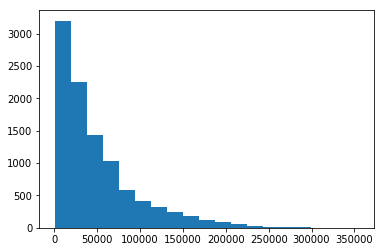

In [543]:
def plot_bins(predictions, number_of_bins):
    import numpy as np
    import matplotlib.pyplot as plt
    bins = np.linspace( predictions.min() - 0.01 , predictions.max() + 0.01, num=number_of_bins)

    def bins_labels(bins, **kwargs):
        bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
        plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
        plt.xlim(bins[0], bins[-1])

    print(bins)
    fig, ax = plt.subplots(1,1)
    hist = ax.hist(predictions , bins=bins)
    labels = [str(count) for count in hist[0]]
    #labels.insert(0, 0)
    print(labels)
    #ax.set_xticklabels(labels)
    plt.show()
    return bins, labels

mnist_bins, mnist_labels = plot_bins(distances, 20)
#fashion_mnist_bins, fashion_mnist_labels = plot_bins(fashion_mnist_predictions, 9)


In [403]:
def print_intervals(bins, labels):
    for index, bin in enumerate(bins[:-1]):
        print("interval: <{:.4f} - {:.4f}, count:{})".format(bins[index] , bins[index  + 1], labels[index]))
#print_intervals(fashion_mnist_bins, fashion_mnist_labels)
print_intervals(mnist_bins, mnist_labels)

interval: <-1.0936 - 11.4774, count:1030.0)
interval: <11.4774 - 24.0484, count:3080.0)
interval: <24.0484 - 36.6194, count:2253.0)
interval: <36.6194 - 49.1904, count:1603.0)
interval: <49.1904 - 61.7615, count:1090.0)
interval: <61.7615 - 74.3325, count:667.0)
interval: <74.3325 - 86.9035, count:211.0)
interval: <86.9035 - 99.4745, count:56.0)
interval: <99.4745 - 112.0455, count:10.0)


interval: <-13.6465 - -9.7059, count:2.0)
interval: <-9.7059 - -5.7653, count:17.0)
interval: <-5.7653 - -1.8247, count:152.0)
interval: <-1.8247 - 2.1159, count:1112.0)
interval: <2.1159 - 6.0565, count:2096.0)
interval: <6.0565 - 9.9971, count:2039.0)
interval: <9.9971 - 13.9377, count:1594.0)
interval: <13.9377 - 17.8783, count:1123.0)
interval: <17.8783 - 21.8189, count:742.0)
interval: <21.8189 - 25.7595, count:481.0)
interval: <25.7595 - 29.7001, count:255.0)
interval: <29.7001 - 33.6407, count:177.0)
interval: <33.6407 - 37.5813, count:94.0)
interval: <37.5813 - 41.5219, count:48.0)
interval: <41.5219 - 45.4625, count:33.0)
interval: <45.4625 - 49.4031, count:17.0)
interval: <49.4031 - 53.3437, count:7.0)
interval: <53.3437 - 57.2843, count:5.0)
interval: <57.2843 - 61.2249, count:6.0)


IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000), rng.normal(loc=5, scale=2, size=1000)))
_ = plt.hist(a, bins=[-5, 0, 5, 10])  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
# from keras.utils import plot_model
# keras.utils.plot_model(models.auto_classifier, show_shapes=True, to_file = 'model_combined.png')
import global_functions, constants, vizualizer, experiments
logs = global_functions.get_files_in_dir_with_extension(constants.Paths.OUTPUT_DIRECTORY, ".json" )


In [ ]:
import vizualizer, experiments
results = experiments.ExperimentBase.load_experiment_results(constants.ExperimentsPaths.FashionMnist.AUTOENCODER2_CLASSIFIER1_AUTO_L_OFF)
vizualizer.Vizualizer.vizualize([result.train_history for result in results], 0.5)

    

In [ ]:
model = results[-1].experiment.model_provider()
model.classifier .summary()

In [ ]:
import vizualizer
import importlib
importlib.reload(vizualizer)
vizualizer.Vizualizer.show_autoencoder_images(datasets.FashionMnistDataset(), data.test_y,  predictions, 5)

In [ ]:
def make_batches(to_batch, batch_size = 128):
    return [to_batch[i * batch_size:(i + 1) * batch_size] for i in range((len(to_batch) + batch_size - 1) // batch_size )]

batch_size = 128
to_batch = tf.data.Dataset.from_tensor_slices((train_images, keras.utils.to_categorical(train_labels, 10) ))
train_batched = to_batch.batch(batch_size)

In [ ]:
epochs = 10
for epoch in range(epochs):
    print("Epoch: {}", epoch)
    for step, (images, labels) in enumerate(train_batched):
        set_autoencoder_trainable(True)
        with tf.GradientTape() as tape:
          prediction = autoencoder(images)
          loss_autoencoder = autoencoder.loss(images, prediction)
          gradients = tape.gradient(loss_autoencoder, autoencoder.trainable_variables)
          autoencoder.optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))  
        set_autoencoder_trainable(False)
        with tf.GradientTape() as tape:
          predict_class = classifier(images)
          loss_classifier = classifier.loss(labels, predict_class)  
#           classiefier_trainable = classifier_head.trainable_variables
          classiefier_trainable = classifier.trainable_variables
          gradients = tape.gradient(loss_classifier, classiefier_trainable)
          classifier.optimizer.apply_gradients(zip(gradients  ,classiefier_trainable) ) 
          if step % 10 == 0:
              print("Step: {}, loss autoencoder: {}, loss classifier: {}".format(step, loss_autoencoder.numpy().mean(), loss_classifier.numpy().mean()))


In [ ]:
for epoch in range(5):
  print("Classifier")
  historyClassifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=1, validation_data= (test_images, test_labels_one_hot_encoding))

In [ ]:
predictions_auto_encoder, predictions_classifier = auto_classifier.predict(test_images)
predictions_classifier = np.argmax(np.round(predictions_classifier),axis=1)
correct = np.where(predictions_classifier==test_labels)[0]
print( "Found {} correct labels".format(len(correct)))

In [ ]:

test_eval = classifier.evaluate(test_images, test_labels_one_hot_encoding, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
predicted_classes = classifier.predict(test_images)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes = predicted_classes.astype('uint8')
correct = [predicted_classes[i] == value for i, value in enumerate(test_labels)]
print("Correct: {}".format( correct.count(True)))


